In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# INTRODUCTION

The aim of this work is to build a convolutional neural network (CNN) that performs binary image classification of metastatic cancer in tissue samples. According to the National Cancer Institute (2024) in the United States alone it is estimated that over 2 million new cases of cancer will be diagnosed and over 600,000 people will die from cancer. The World Health Organization (2023) emphasizes the importance of early cancer diagnosis in fighting the disease. Early detection increases the success rate of treatments, deceases the severity of side effects from treatment, and lowers cost of care (World Health Organization, 2023). This data set contains images of metastatic cancer. The National Cancer Institute defines metastasis as the spread of cancer cells from the place where they first formed to other parts of the body. Given the prevalence of cancer and the importance of early detection in its treatment, a model that can detect cancer in tissue images could help improve the outcome of those suffering from the disease.

# REFERENCES

**Data**

Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection

**Content**

Cancer statistics. (2024, May 9). National Cancer Institute. https://www.cancer.gov/about-cancer/understanding/statistics

Promoting cancer early diagnosis. (2023, October 27). World Health Organization. https://www.who.int/activities/promoting-cancer-early-diagnosis

Verma, M. (2024, May 17). Binary classification using Convolution Neural Network (CNN) model. Medium. https://medium.com/@mayankverma05032001/binary-classification-using-convolution-neural-network-cnn-model-6e35cdf5bdbb


# LIBRAIRIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from glob import glob
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# DATA DESCRIPTION

The data is split into training samples with labels included as a csv file, and testing samples. The problem is to build and train a CNN for binary image classification of metastatic cancer in tissue samples using the labeled training data, then evaluate the performance of the model with the test data. Images that are positive for cancer will have at least one pixel in a 32 by 32-pixel center region that is tumor tissue. Tissue outside of the center region does not influence the label. The training set includes 220,025 images and the test set includes 57,458 images.


## Data Directories

In [3]:
# Define directories
directory  = '../input/histopathologic-cancer-detection'  
labels_path = os.path.join(directory, 'train_labels.csv')
train_path = os.path.join(directory, 'train')
test_path = os.path.join(directory, 'test')

## Number of Samples

In [4]:
print('There are ',len(os.listdir(train_path)), 'training images and ',len(os.listdir(test_path)), 'testing images.')


There are  220025 training images and  57458 testing images.


# EXPLORATORY DATA ANALYSIS, DATA CLEANING, AND PROCESSING
The first task is to load the data and attach the labels to the training data. Approximately 59.5% of the tissue samples are cancer free tissue and 40.50% of the tissue samples are positive for cancer in the training data. There are no null values or duplicated images. Images are 96 by 96, and the max number of pixels is 255. The data set is large, so data augmentation using a data generator used. 

## Load Data and Add Labels to Training Data

In [5]:
# load the CSV file containing labels
labels = pd.read_csv(labels_path)

# create a DataFrame to match training data images with labels
train = pd.DataFrame({'path': glob(os.path.join(train_path, '*.tif'))}) 
train['id'] = train['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])  # Extract image ID to merge with training labels
train = train.merge(labels, on='id')  

# convert labels to strings
train['label'] = train['label'].astype(str)

# ensure paths are relative to train_path
train['path'] = train['path'].apply(lambda x: os.path.basename(x))

print(train.head())

                                           path  \
0  d43c081bafa286f9c1f7e921883f26ceafebc912.tif   
1  092d0eedebce504847715ee046b6ad74b57599b4.tif   
2  b0d2582c6218a8764323fc940b41312282b99bf4.tif   
3  187c99df762f13f99818e5593d4bab4c6577e7e3.tif   
4  7c5270c83837de5a5cbb2dca511559dc39d19d53.tif   

                                         id label  
0  d43c081bafa286f9c1f7e921883f26ceafebc912     1  
1  092d0eedebce504847715ee046b6ad74b57599b4     0  
2  b0d2582c6218a8764323fc940b41312282b99bf4     0  
3  187c99df762f13f99818e5593d4bab4c6577e7e3     1  
4  7c5270c83837de5a5cbb2dca511559dc39d19d53     1  


## Check for Null and Missing Data

In [6]:
# check for null values
print('There are ',train.isnull().sum().sum(), ' null values')
# check for duplicates
print('There are ', train.duplicated().sum(),' duplicated images')

There are  0  null values
There are  0  duplicated images


## Inspect Image Shape and Size
This will be important information when building the data generator and CNN model.

In [7]:
# randomly select one image path
image_path = random.choice(train['path'].values)
# full path to the image
full_image_path = os.path.join(train_path, image_path)
# Load the selected image 
selected_image = cv2.imread(full_image_path)

print('Image shape is ', selected_image.shape)
print('The maximum number of pixels is ', selected_image.max())

Image shape is  (96, 96, 3)
The maximum number of pixels is  255


## Tissue Image Examples
It is difficult to distinguish between cancerous and non-cancerous tissue by simply looking at the images. With the help of a CNN will hopefully we will be able to differentiate between these groups.

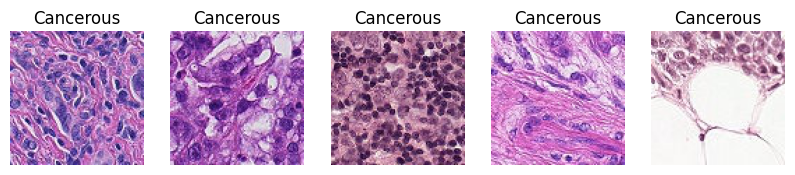

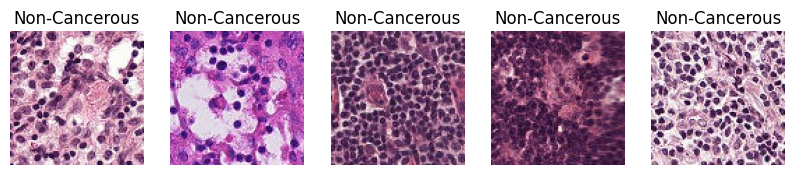

In [8]:
## Separate cancerous and non-cancerous data
cancerous = train[train['label'] == '1']['id'].sample(n=5).values  # Ensure labels are treated as strings
noncancerous = train[train['label'] == '0']['id'].sample(n=5).values

cancerous_images = []
for id in cancerous:
    image_path = os.path.join(train_path, id + '.tif')
    cancerous_images.append(Image.open(image_path))

noncancerous_images = []
for id in noncancerous:
    image_path = os.path.join(train_path, id + '.tif')
    noncancerous_images.append(Image.open(image_path))

plt.figure(figsize=(10, 5))
for i, image in enumerate(cancerous_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title('Cancerous')
    plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
for i, image in enumerate(noncancerous_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title('Non-Cancerous')
    plt.axis('off')
plt.show()


## Distribution of Classes
There is a slight class imbalance but not too bad given the large number of images in the dataset.

Positive labels in training data: 40.50%


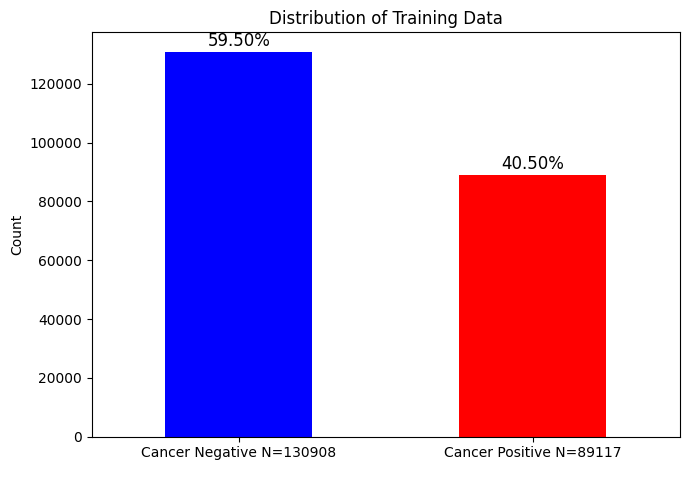

In [9]:
# Counts for each class
label_counts = labels['label'].value_counts()

# Calculate the percentages of each class
positive_percentage = label_counts[1] / (label_counts[0] + label_counts[1])
print(f'Positive labels in training data: {positive_percentage:.2%}')

# Create bar plot 
plt.figure(figsize=(7, 5))
ax = label_counts.sort_index().plot(kind='bar', color=['blue', 'red'])

plt.xticks([0, 1], labels=[f"Cancer Negative N={label_counts[0]}", f"Cancer Positive N={label_counts[1]}"], rotation=0)

for i, count in enumerate(label_counts):
    percentage = count / label_counts.sum() * 100
    ax.text(i, count + 500, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=12)

plt.title(f'Distribution of Training Data')
plt.ylabel('Count')
plt.xlabel(" ")
plt.tight_layout()
plt.show()

## Build Data Generators

Analyzing all the training data will be very memory intensive, therefore data generators will be used to preprocess images and load batches. Data generators will be implemented using TensorFlow’s ImageDataGenerator function. 

In [10]:
# split the data into 80% training and 20% validation sets
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

# data generator for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,  # scale images from integers 0-255 to 0-1
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,  # horizontal flip of images
)

# data generator for validation images without augmentation
validation_datagen = ImageDataGenerator(
    rescale=1./255,  # scale images from integers 0-255 to 0-1
)

batch_size = 32

# generator for the training set
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_path,
    x_col='path',
    y_col='label',
    target_size=(96, 96), # image shape
    batch_size=batch_size,
    class_mode='binary'
)

# generator for the validation set
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,  
    directory=train_path,
    x_col='path',
    y_col='label',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='binary'
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


# CNN MODELS


## First Model Architecture 
This model has 3 convolution layers, each of which uses a relu activation function. The relu activation function replaces all negative pixel values with zero. The first layer has 32 nodes with mask size 3X3, the 2nd layer contains 64 nodes with mask size 3X3, and the 3rd layer has 128 nodes also with a 3X3 mask. Each convolution layer is followed by a max pooling layer. The max pooling layers will reduce the dimensionality of each feature by selecting the features with the maximum value. The layers will then be flattened and put into a dense, fully connected layer. To help prevent overfitting, before the final output layer is a dropout step set to 0.5. Resulting in 50% of the neurons in the layer to be randomly ignored during each training step. Since this is a binary classification problem the final layer will be a single neuron with a sigmoid activation function. 

In [11]:
model_1 = Sequential([
    Input(shape=(96, 96, 3)),  # define input shape
    Conv2D(32, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),  # dropout layer with 50% dropout rate
    Dense(1, activation='sigmoid')  # one output neuron and sigmoid activation for binary classification
])

model_1.compile(loss='binary_crossentropy', metrics=['accuracy', 'auc'])

### Model 1 Summary

In [12]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 912,577 (3.48 MB)

 Trainable params: 912,577 (3.48 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
hist_1 = model_1.fit(
    train_generator,
    steps_per_epoch=100,
    validation_data=validation_generator,
    validation_steps=20,
    epochs = 10
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 402ms/step - accuracy: 0.6629 - auc: 0.6988 - loss: 0.6141 - val_accuracy: 0.6531 - val_auc: 0.7338 - val_loss: 0.6169
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 390ms/step - accuracy: 0.7297 - auc: 0.7802 - loss: 0.5682 - val_accuracy: 0.6906 - val_auc: 0.8428 - val_loss: 0.5603
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 393ms/step - accuracy: 0.7346 - auc: 0.7865 - loss: 0.5509 - val_accuracy: 0.6656 - val_auc: 0.8128 - val_loss: 0.8217
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 360ms/step - accuracy: 0.7750 - auc: 0.8266 - loss: 0.5097 - val_accuracy: 0.7406 - val_auc: 0.7962 - val_loss: 0.5428
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 345ms/step - accuracy: 0.7789 - auc: 0.8225 - loss: 0.5123 - val_accuracy: 0.7688 - val_auc: 0.8535 - val_loss: 0.4690
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 361ms/step - accuracy: 0.7855 - auc: 0.8483 - loss: 0.4793 - val_accuracy: 0.7719 - val_auc: 0.8374 - val_loss: 0.4968
Epoch 7/10
100/100 ━━━

## Model 1 Results
The first model did well, but there is certainly room for improvement. As the number of epochs increased the accuracy and loss improved for training and validation data, reaching an accuracy of almost 77.5% for the training data and 80% for the validation data. However, looking at the confusion matrix there are many instances of cancerous tissue being labeled as non-cancerous, which is problematic for a model that is being designed to detect cancer. Also, there was a large amount of instability in the validation loss and accuracy, indicating the model may be over fitting.


### Model 1 Accuracy, Loss, and ROC AUC Plots

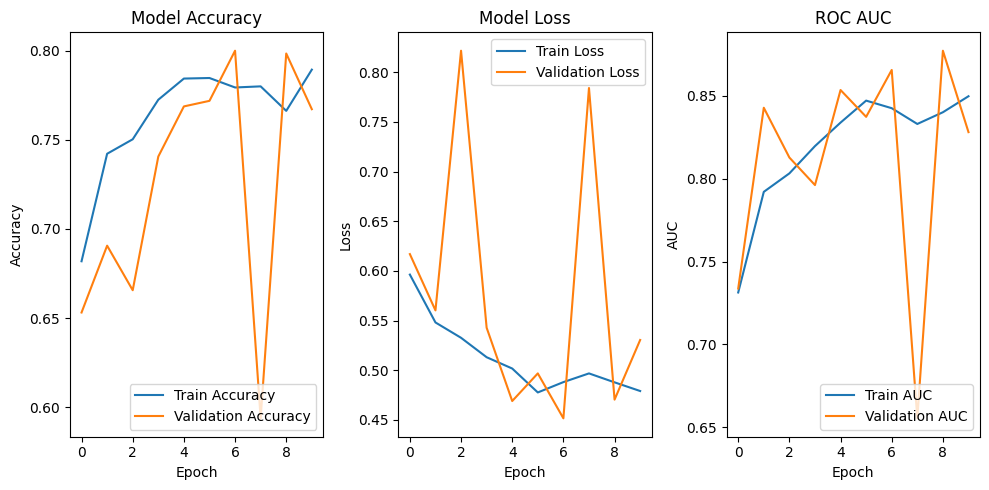

In [15]:
plt.figure(figsize=(10, 5))

# accuracy plot
plt.subplot(1, 3, 1)
plt.plot(hist_1.history['accuracy'], label='Train Accuracy')
plt.plot(hist_1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(loc='lower right')

# loss plot
plt.subplot(1, 3, 2)
plt.plot(hist_1.history['loss'], label='Train Loss')
plt.plot(hist_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(loc='upper right')

# AUC plot
plt.subplot(1, 3, 3)
plt.plot(hist_1.history['auc'], label='Train AUC')
plt.plot(hist_1.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('ROC AUC')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Model 1 Confusion Matrix

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 292s 213ms/step


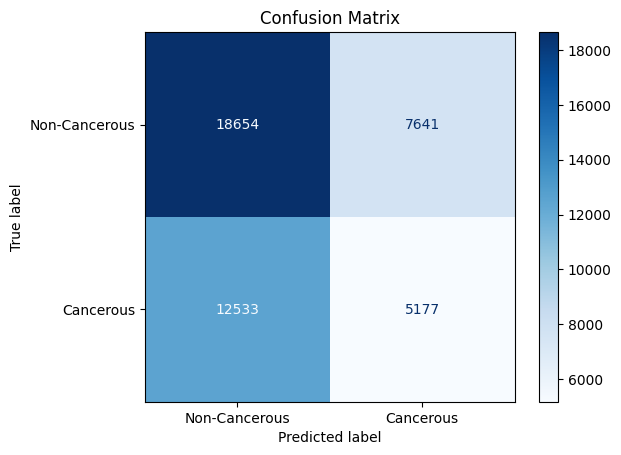

In [16]:
# calculations for confusion matrix
true_labels1 = validation_generator.classes
pred_probabilities1 = model_1.predict(validation_generator, steps=len(validation_generator), verbose=1)

# for binary classification get predicted classes based on probability threshold of 0.5
pred_classes1 = (pred_probabilities1 > 0.5).astype(int)

# confusion matrix
cm1 = confusion_matrix(true_labels1, pred_classes1)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Second Model Architecture 
Model 2 has a similar architecture as the first model. The only difference in architecture is that dropout layers of 25% have been added after each pooling layer to help address the possible issue of overfitting seen in the initial model. Another change with the second model is the addition of adam optimization, which helps with gradient descent. The number of epochs was increased from 10 to 25 because the accuracy and loss measurements seemed to still be improving at 10 epochs.  

In [24]:
model_2 = Sequential([
    Input(shape=(96, 96, 3)),  # define input shape
    Conv2D(32, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)),
    Dropout(0.25), # dropout layer with 25% dropout rate
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # dropout layer with 25% dropout rate
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # dropout layer with 25% dropout rate
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),  # dropout layer with 50% dropout rate
    Dense(1, activation='sigmoid')  # one output neuron and sigmoid activation for binary classification
])

# add adam optimizer and set learning rate to 0.0001
model_2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'auc'])

### Model 2 Summary

In [25]:
model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 912,577 (3.48 MB)

 Trainable params: 912,577 (3.48 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
hist_2 = model_2.fit(
    train_generator,
    steps_per_epoch=25,
    validation_data=validation_generator,
    validation_steps=10,
    epochs=25
)

Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 383ms/step - accuracy: 0.5891 - auc: 0.5480 - loss: 0.6829 - val_accuracy: 0.5813 - val_auc: 0.6828 - val_loss: 0.6770
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step - accuracy: 0.6120 - auc: 0.5249 - loss: 0.6693 - val_accuracy: 0.6156 - val_auc: 0.6465 - val_loss: 0.6717
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - accuracy: 0.6243 - auc: 0.6514 - loss: 0.6422 - val_accuracy: 0.5625 - val_auc: 0.6951 - val_loss: 0.6772
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 346ms/step - accuracy: 0.6181 - auc: 0.6395 - loss: 0.6443 - val_accuracy: 0.6562 - val_auc: 0.7377 - val_loss: 0.6691
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step - accuracy: 0.6119 - auc: 0.6809 - loss: 0.6461 - val_accuracy: 0.7094 - val_auc: 0.7233 - val_loss: 0.6363
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - accuracy: 0.6402 - auc: 0.7013 - loss: 0.6253 - val_accuracy: 0.7469 - val_auc: 0.7777 - val_loss: 0.5839
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 9

## Model 2 Results
The addition of dropout layers did improve the problem of overfitting. Also increasing the number of epochs helped ensure the model converged. These changes did not help the accuracy of the model, and the model was still labeling many cancerous images as non-cancerous.

### Model 2 Accuracy, Loss, and ROC AUC Plots

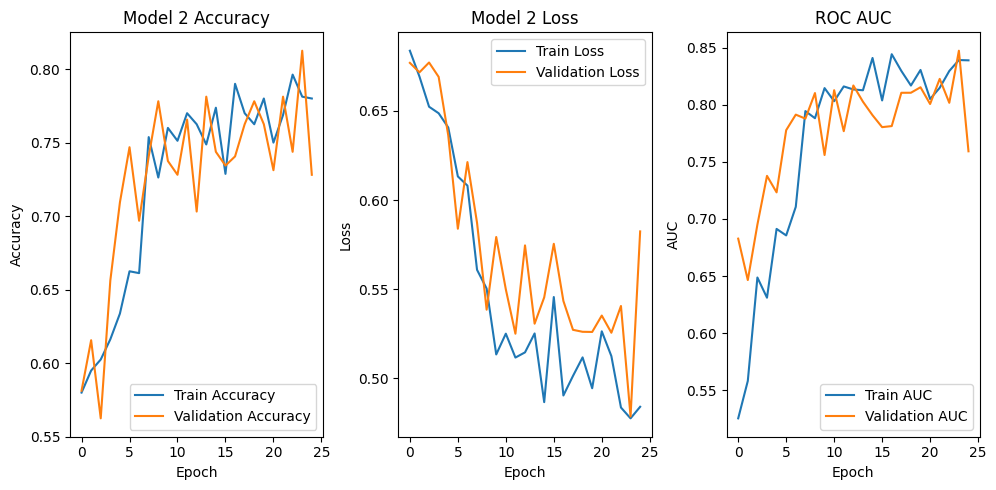

In [27]:
plt.figure(figsize=(10, 5))

# accuracy plot
plt.subplot(1, 3, 1)
plt.plot(hist_2.history['accuracy'], label='Train Accuracy')
plt.plot(hist_2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2 Accuracy')
plt.legend(loc='lower right')

# loss plot
plt.subplot(1, 3, 2)
plt.plot(hist_2.history['loss'], label='Train Loss')
plt.plot(hist_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 Loss')
plt.legend(loc='upper right')

# AUC plot
plt.subplot(1, 3, 3)
plt.plot(hist_2.history['auc'], label='Train AUC')
plt.plot(hist_2.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('ROC AUC')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Model 2 Confusion Matrix

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 108s 78ms/step


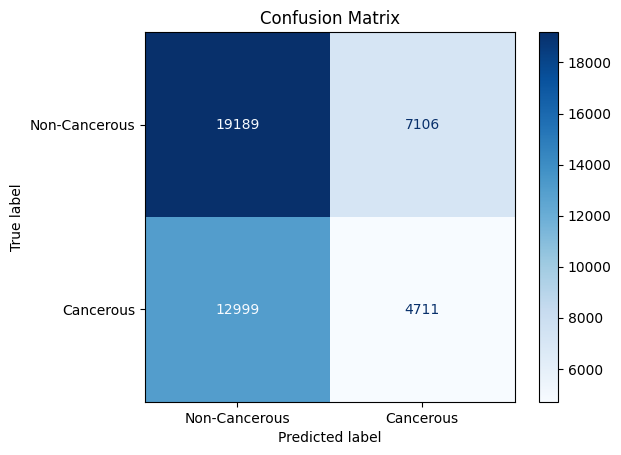

In [28]:
# calculations for confusion matrix
true_labels2 = validation_generator.classes
pred_probabilities2 = model_2.predict(validation_generator, steps=len(validation_generator), verbose=1)

# for binary classification get predicted classes based on probability threshold of 0.5
pred_classes2 = (pred_probabilities2 > 0.5).astype(int)

# confusion matrix
cm2 = confusion_matrix(true_labels2, pred_classes2)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Third Model Architecture 
To help improve the model’s performance batch normalization was implemented. This is a regularization technique applied during training. The rest of the model’s architecture is the mostly the same as the second model. The main differences are that the activation step is moved to after the normalization, and the learning rate is set to 0.001. 

In [75]:
model_3 = Sequential([
    Input(shape=(96, 96, 3)),  # define input shape
    Conv2D(32, (3, 3), activation=None), 
    BatchNormalization(),
    Activation('relu'), # activation after batch normalization
    MaxPooling2D((2, 2)),
    Dropout(0.25), # dropout layer with 25% dropout rate
    
    Conv2D(64, (3, 3), activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # dropout layer with 25% dropout rate
    
    Conv2D(128, (3, 3), activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # dropout layer with 25% dropout rate
    
    Flatten(),
    Dense(64, activation=None), # , kernel_regularizer=l2(0.001) added L2 regularization 
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),  # dropout layer with 50% dropout rate
    # added L2 regularization  kernel_regularizer=l2(0.001)
    Dense(1, activation='sigmoid')  # one output neuron and sigmoid activation for binary classification
])

# adam optimizer and learning rate to 0.001
model_3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'auc'])

### Model 3 Summary

In [76]:
model_3.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 913,729 (3.49 MB)

 Trainable params: 913,153 (3.48 MB)

 Non-trainable params: 576 (2.25 KB)

In [77]:
hist_3 = model_3.fit(
    train_generator,
    steps_per_epoch=50,
    validation_data=validation_generator,
    validation_steps=10,
    epochs=25
)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 499ms/step - accuracy: 0.6537 - auc: 0.7575 - loss: 0.7314 - val_accuracy: 0.5688 - val_auc: 0.6395 - val_loss: 0.6773
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 482ms/step - accuracy: 0.7466 - auc: 0.7988 - loss: 0.5514 - val_accuracy: 0.3781 - val_auc: 0.6155 - val_loss: 1.7937
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 488ms/step - accuracy: 0.7869 - auc: 0.8275 - loss: 0.4928 - val_accuracy: 0.6062 - val_auc: 0.6416 - val_loss: 1.2197
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 488ms/step - accuracy: 0.7901 - auc: 0.8258 - loss: 0.4921 - val_accuracy: 0.3750 - val_auc: 0.6652 - val_loss: 2.5010
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 483ms/step - accuracy: 0.7774 - auc: 0.8526 - loss: 0.4743 - val_accuracy: 0.4437 - val_auc: 0.6594 - val_loss: 2.3512
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 488ms/step - accuracy: 0.8074 - auc: 0.8682 - loss: 0.4549 - val_accuracy: 0.4125 - val_auc: 0.7574 - val_loss: 1.7029
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━

## Model 3 Results
Although the addition of batch normalization improved the model’s performance on the training data the model did not perform well with the validation data. There was a large amount of instability in the validation data, which can be seen in the accuracy, loss, and ROC AUC plots. This could indicate problems with overfitting. 

### Model 3 Accuracy, Loss, and ROC AUC Plots

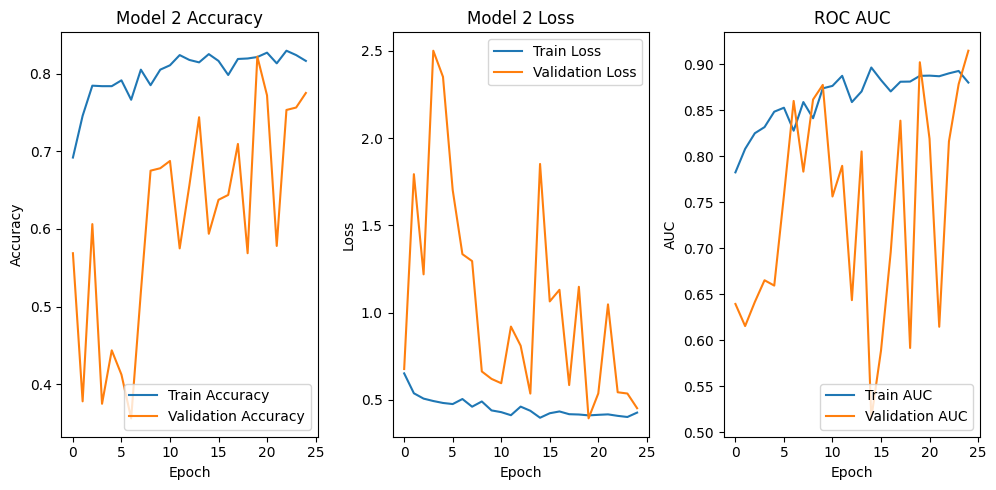

In [78]:
plt.figure(figsize=(10, 5))

# accuracy plot
plt.subplot(1, 3, 1)
plt.plot(hist_3.history['accuracy'], label='Train Accuracy')
plt.plot(hist_3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2 Accuracy')
plt.legend(loc='lower right')

# loss plot
plt.subplot(1, 3, 2)
plt.plot(hist_3.history['loss'], label='Train Loss')
plt.plot(hist_3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 Loss')
plt.legend(loc='upper right')

# AUC plot
plt.subplot(1, 3, 3)
plt.plot(hist_3.history['auc'], label='Train AUC')
plt.plot(hist_3.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('ROC AUC')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Model 3 Confusion Matrix

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 126s 91ms/step


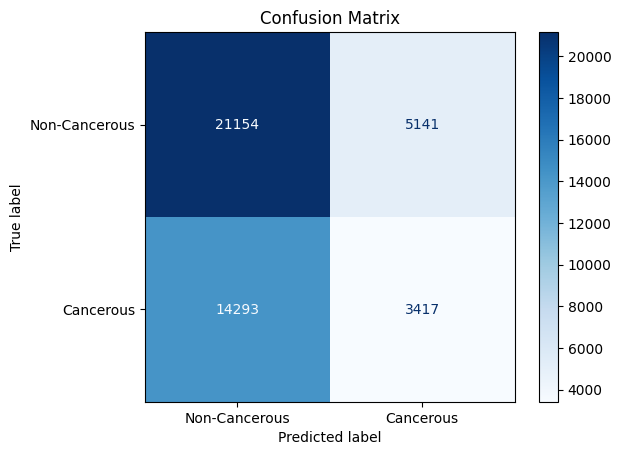

In [79]:
# calculations for confusion matrix
true_labels3 = validation_generator.classes
pred_probabilities3 = model_3.predict(validation_generator, steps=len(validation_generator), verbose=1)

# for binary classification get predicted classes based on probability threshold of 0.5
pred_classes3 = (pred_probabilities3 > 0.5).astype(int)

# confusion matrix
cm3 = confusion_matrix(true_labels3, pred_classes3)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Fourth Model Architecture 
This model had very similar architecture to the second model with the addition of another 3 by 3 convolution layer with 64 nodes after the first convolution layer and before the first pooling layer. This model is like the one successfully used by Verma (2024) to classify X-ray images of individuals with covid 19 infections. The one difference with my model is the addition of kernel regularization to help address issues with overfitting. 

In [147]:
model_4 = Sequential([
    Input(shape=(96, 96, 3)),  # define input shape
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)),
    Dropout(0.3), # dropout layer with 30% dropout rate
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3), # dropout layer with 30% dropout rate
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3), # dropout layer with 30% dropout rate
    
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)), #   added L2 regularization 
    Dropout(0.5),  # dropout layer with 50% dropout rate
    # added L2 regularization  
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))  # one output neuron and sigmoid activation for binary classification
])

# adam optimizer and learning rate to 0.001
model_4.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'auc'])

### Model 4 Summary

In [148]:
model_4.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_101 (Conv2D)             │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 92, 92, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_93 (MaxPooling2D) │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 44, 44, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_94 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_95 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 64)             │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 949,505 (3.62 MB)

 Trainable params: 949,505 (3.62 MB)

 Non-trainable params: 0 (0.00 B)

In [151]:
hist_4 = model_4.fit(
    train_generator,
    steps_per_epoch=50,
    validation_data=validation_generator,
    validation_steps=10,
    epochs=25
)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 796ms/step - accuracy: 0.7864 - auc: 0.8528 - loss: 0.4732 - val_accuracy: 0.7750 - val_auc: 0.8570 - val_loss: 0.4656
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 780ms/step - accuracy: 0.8199 - auc: 0.8804 - loss: 0.4484 - val_accuracy: 0.6938 - val_auc: 0.8374 - val_loss: 0.6213
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 782ms/step - accuracy: 0.7765 - auc: 0.8287 - loss: 0.5028 - val_accuracy: 0.7094 - val_auc: 0.7885 - val_loss: 0.5714
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 778ms/step - accuracy: 0.7942 - auc: 0.8472 - loss: 0.4800 - val_accuracy: 0.7344 - val_auc: 0.8606 - val_loss: 0.5882
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 791ms/step - accuracy: 0.7973 - auc: 0.8441 - loss: 0.4795 - val_accuracy: 0.8281 - val_auc: 0.8907 - val_loss: 0.4301
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 782ms/step - accuracy: 0.7925 - auc: 0.8431 - loss: 0.5054 - val_accuracy: 0.8094 - val_auc: 0.8925 - val_loss: 0.4354
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━

## Model 4 Results
The addition of one more convolution layer and kernel regularization did have a positive impact on the model’s performance. This seemed to be the best performing model with an accuracy over 80% and over 85% AUC and is the one I submitted to Kaggle.

### Model 4 Accuracy, Loss, and ROC AUC Plots

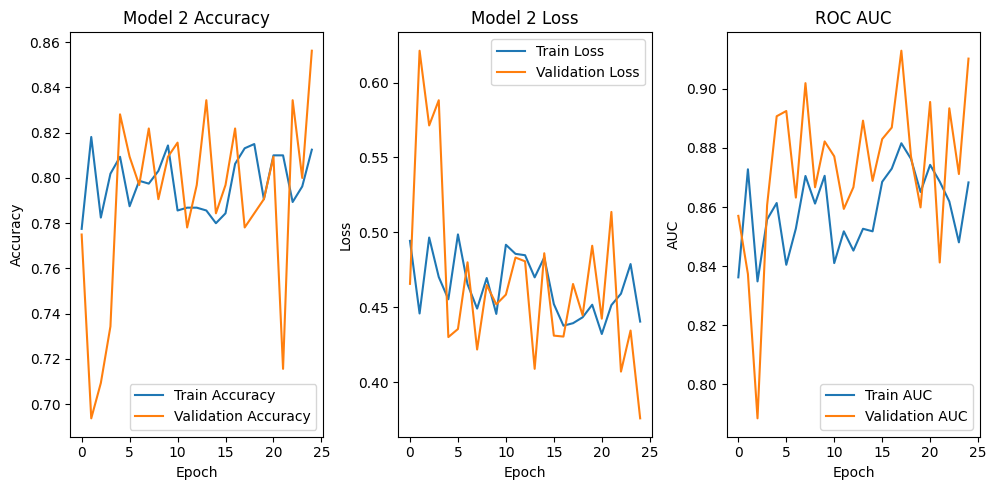

In [152]:
plt.figure(figsize=(10, 5))

# accuracy plot
plt.subplot(1, 3, 1)
plt.plot(hist_4.history['accuracy'], label='Train Accuracy')
plt.plot(hist_4.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2 Accuracy')
plt.legend(loc='lower right')

# loss plot
plt.subplot(1, 3, 2)
plt.plot(hist_4.history['loss'], label='Train Loss')
plt.plot(hist_4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 Loss')
plt.legend(loc='upper right')

# AUC plot
plt.subplot(1, 3, 3)
plt.plot(hist_4.history['auc'], label='Train AUC')
plt.plot(hist_4.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('ROC AUC')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Model 4 Confusion Matrix

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 278s 202ms/step


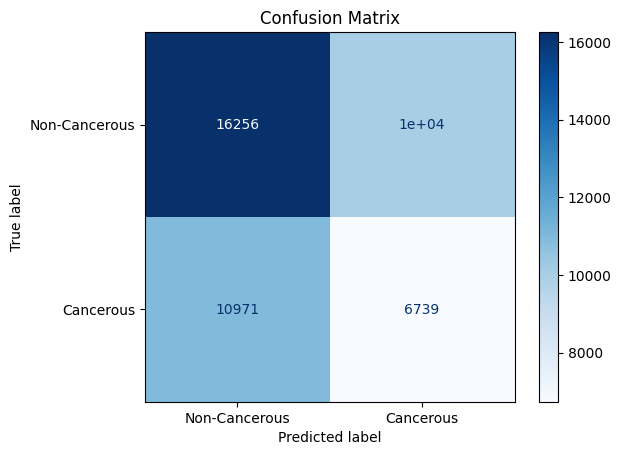

In [153]:
# calculations for confusion matrix
true_labels4 = validation_generator.classes
pred_probabilities4 = model_4.predict(validation_generator, steps=len(validation_generator), verbose=1)

# for binary classification get predicted classes based on probability threshold of 0.5
pred_classes4 = (pred_probabilities4 > 0.5).astype(int)

# confusion matrix
cm4 = confusion_matrix(true_labels4, pred_classes4)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# CONCLUSION
Adding adam optimization to the first model without changing any other parameters did not have much of an impact on the model (data not shown). For the second model adding adam optimization as well as dropout layers after each of the pooling layers set to 25% did improve the model’s performance by helping to address overfitting. Also, decreasing the learning rate did not have a dramatic effect on the model, however increasing the learning rate negatively impacted performance (data not shown). Surprisingly batch normalization was detrimental to the model and resulted in severe overfitting. Adding an additional convolution layer and kernel regularization resulted in the best model, but there is still room for improvement with many tissue samples that are positive for cancer being labeled non-cancerous. 

There are several parameters to experiment with to help improve the model’s performance. Based on visual inspection I noticed that the images had different colors, some had a blue or purple hue, and some seemed to be grey scale. The input shape is (96, 96, 3) indicating that color is a feature of importance in this model. It could be helpful to do some research and find out if color is an important feature in these images. If not, normalizing the images to grey scale may improve the model by decreasing the complexity of the data. Also, all the models used the same data augmentation parameters. There are several aspects of data augmentation that could be optimized to improve the model’s performance, such as batch size, adjusting the brightness, zooming, and image position. Early stopping could also be included in future models to stop training when the validation performance drops. Adding more convolution layers may also help improve the model. 
